# **Time Series and Finance**

In [4]:
import itertools
import pandas as pd
import numpy as np
from random import gauss
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from scipy.stats import shapiro, probplot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
# Setup
data = 'data/'

class CFG:
    img_dim1 = 12
    img_dim2 = 7
    fontsize = 8
    marker = 2
    lines = 1.5

# plt.rcParams.keys() to list params
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2),
                     'font.size': (CFG.fontsize),
                     'lines.markersize': (CFG.marker),
                     'lines.linewidth': (CFG.lines)})   

## **Volatility Clustering**

Continuing with the `Tata Steel` dataset from the previous NB in the series, let's model one of the most challenging aspects of financial data i.e. **volatility**, especially as it pertains to stocks and financial markets. 

The subject of finanical volatility is an entire field of study for obvious reasons. But, for starters, we can plot the volume weighted average price of the aforementioned stock and observe the oscillations over a relatively long time horizon. Here large oscillations are indicative of high volatility and periods of turbulance.

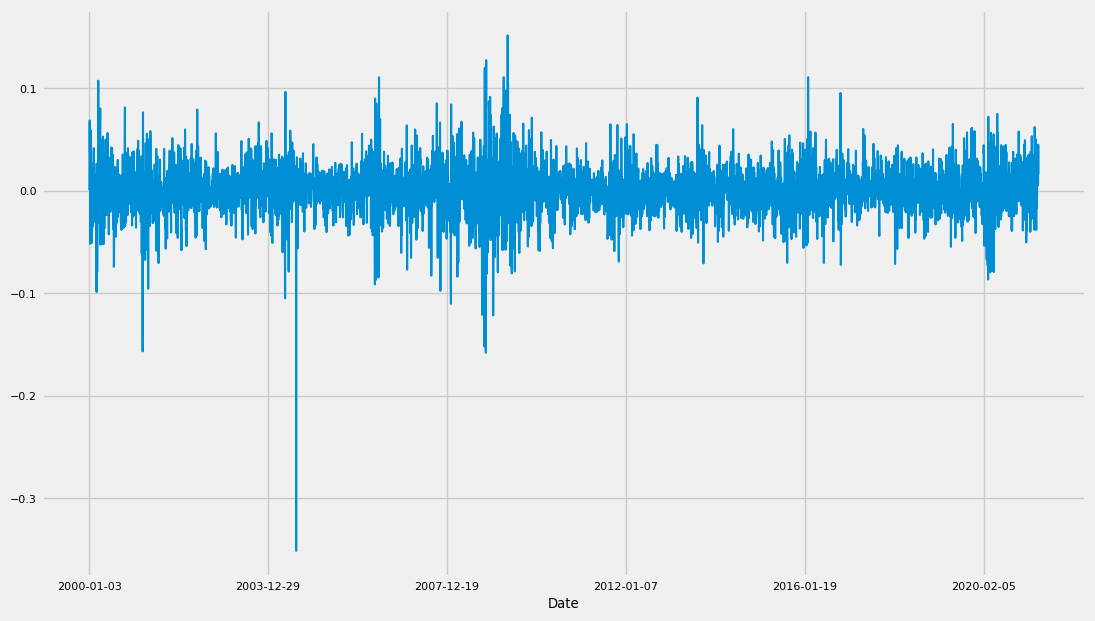

In [11]:
stock = 'TATASTEEL'
df = pd.read_csv('data/nifty50-stocks/' + stock + '.csv')
df.set_index('Date', drop=False, inplace=True)

df.VWAP.pct_change().plot();

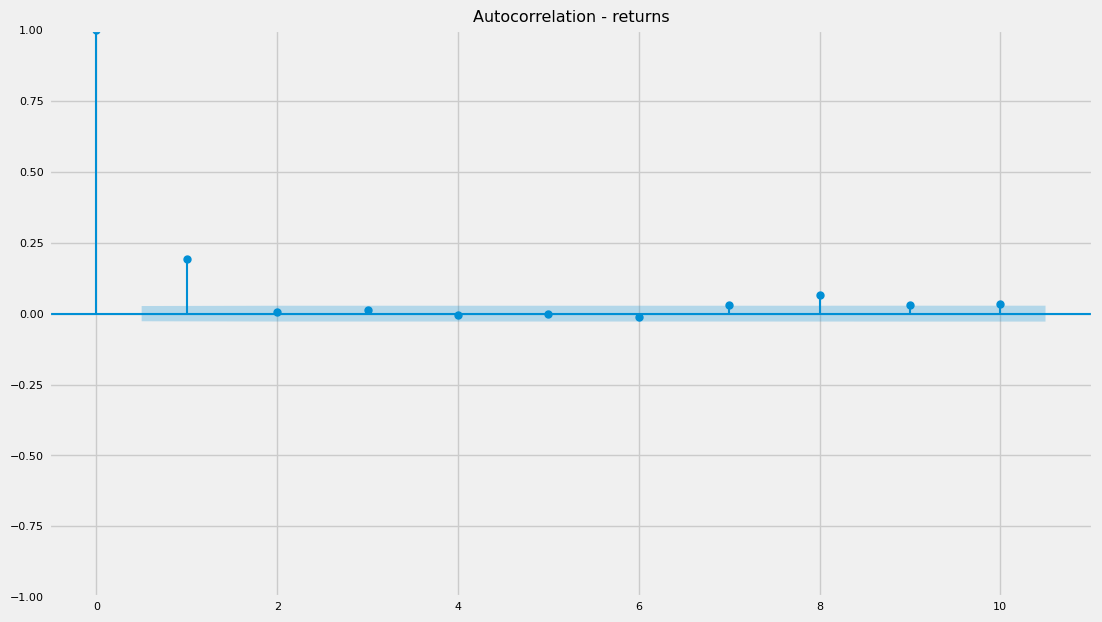

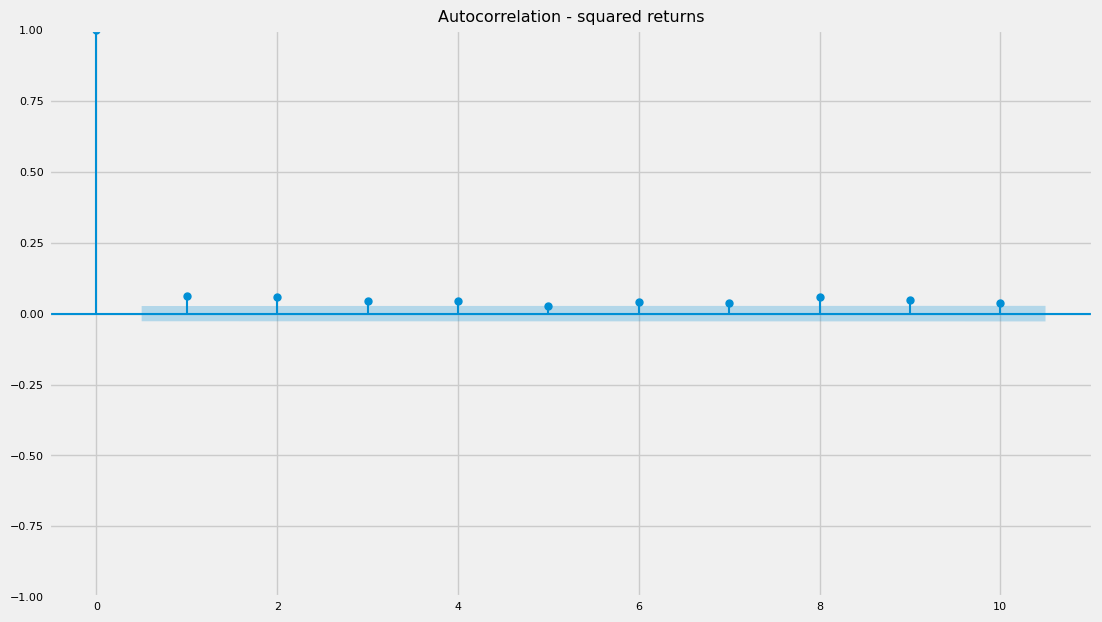

In [14]:
# Dropping nulls and plotting acf for returns and squared returns
df1 = np.log1p(df.VWAP).diff().dropna()

plot_acf(df1, lags=10, title='Autocorrelation - returns'); print()
plot_acf(df1**2, lags=10, title='Autocorrelation - squared returns'); print()

- Autocorr. on `returns` helps us determine if there is a linear dependance in the actual values of the series.
- Doing the same for `squared returns` gives a diagnostic view into serial dependance.

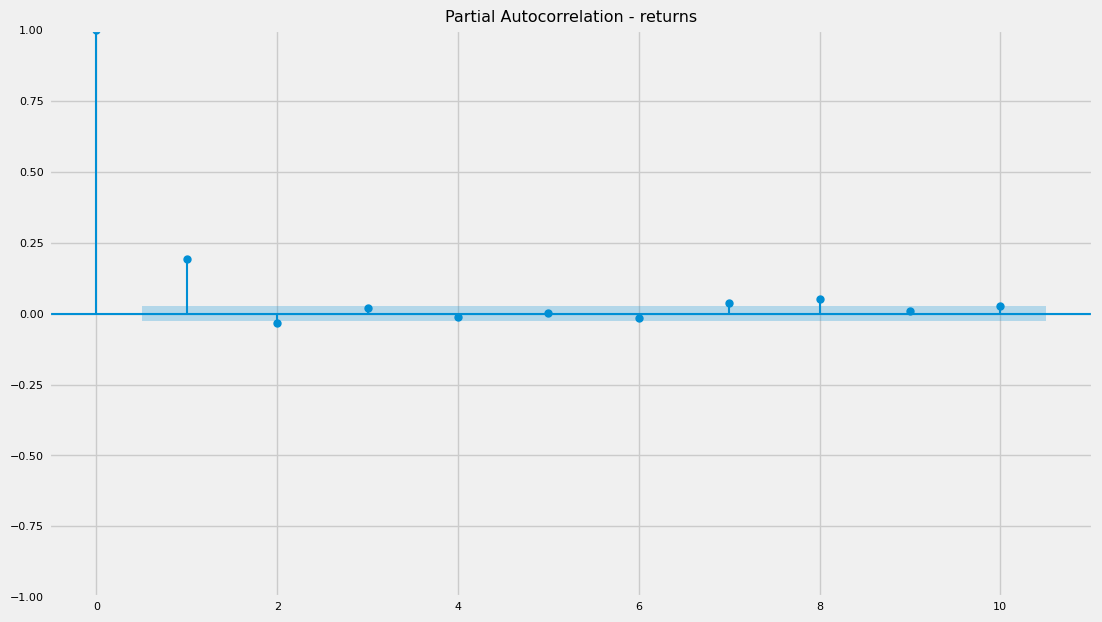

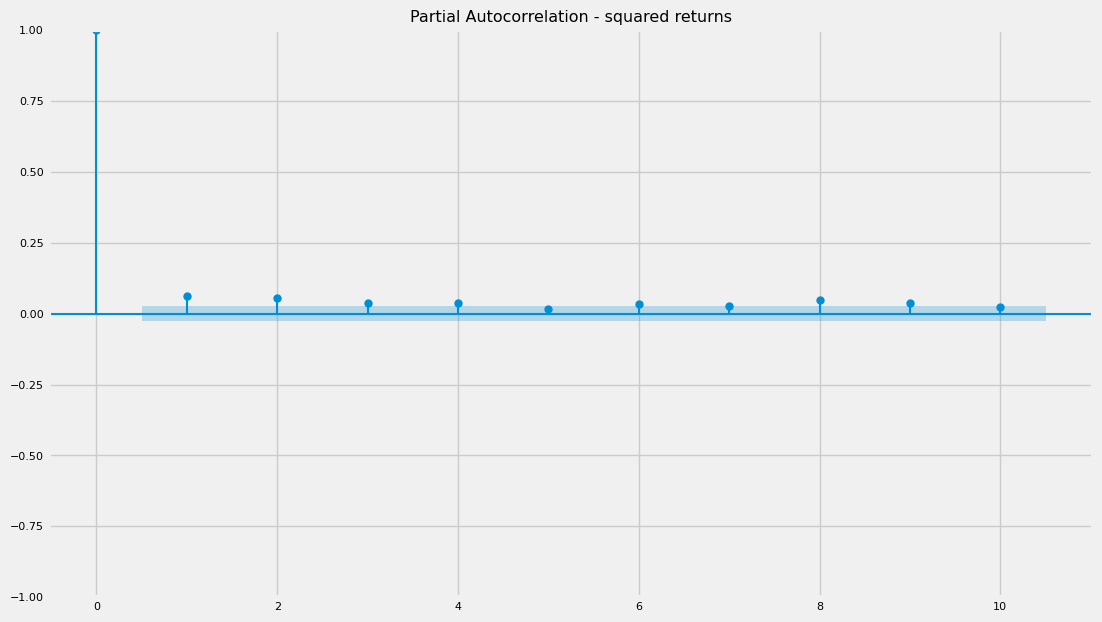

In [15]:
# Now plotting pacf
plot_pacf(df1, lags=10, title='Partial Autocorrelation - returns'); print()
plot_pacf(df1**2, lags=10, title='Partial Autocorrelation - squared returns'); print()

So, we've established that the VWAP for the stock has serial dependance.

## **Application of Mean and Variance Models**

We will apply logic similar to that from the previous NB i.e. a linear model can be specified to predict expected values. Here we will attempt to model variance of the residuals from another model and not the target values themselves.

### ARCH (Auto-Regressive Conditional Heteroskedasticity)

This is the simplest model for variance over a time period.

In [16]:
am = arch_model(100 * df1, p=1, q=0) # Scaling by 100 to account for very small floating point values.
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 12129.135691668853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12129.1066722275
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -12129.1
Distribution:                  Normal   AIC:                           24264.2
Method:            Maximum Likelihood   BIC:                           24283.9
                                        No. Observations:                 5305
Date:                Mon, Aug 26 2024   Df Residuals:                     5304
Time:                        17:06:42   Df Model:                            1
          

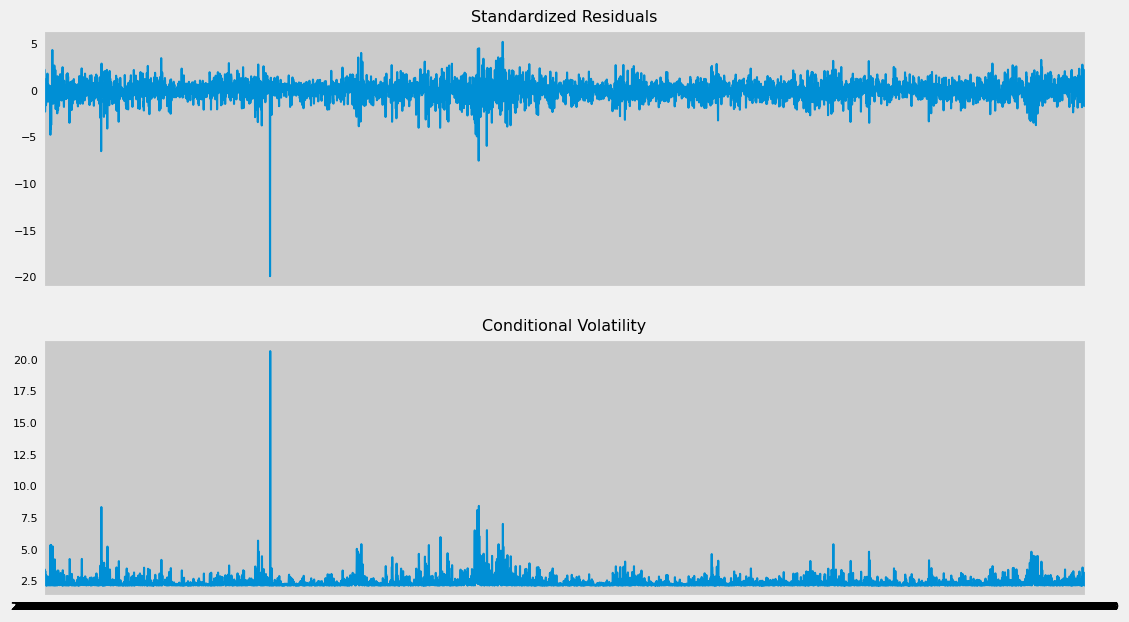

In [17]:
res.plot(); print()

Here the variance of the noise component is **not** constant over time, which is a depature from the underlying assumption used with ARIMA models. 

So different moments over the modelled time horizon have differing volatility and this sort of data is better suited for the GARCH model.

In [18]:
max_lags = 5
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)

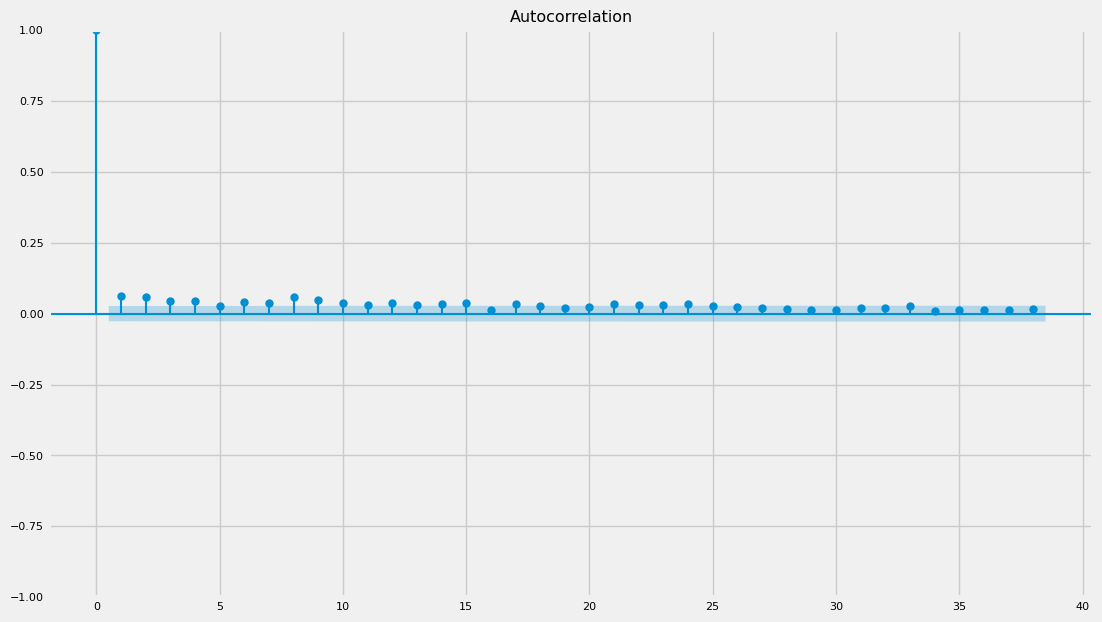

In [19]:
plot_acf(df1**2); print()

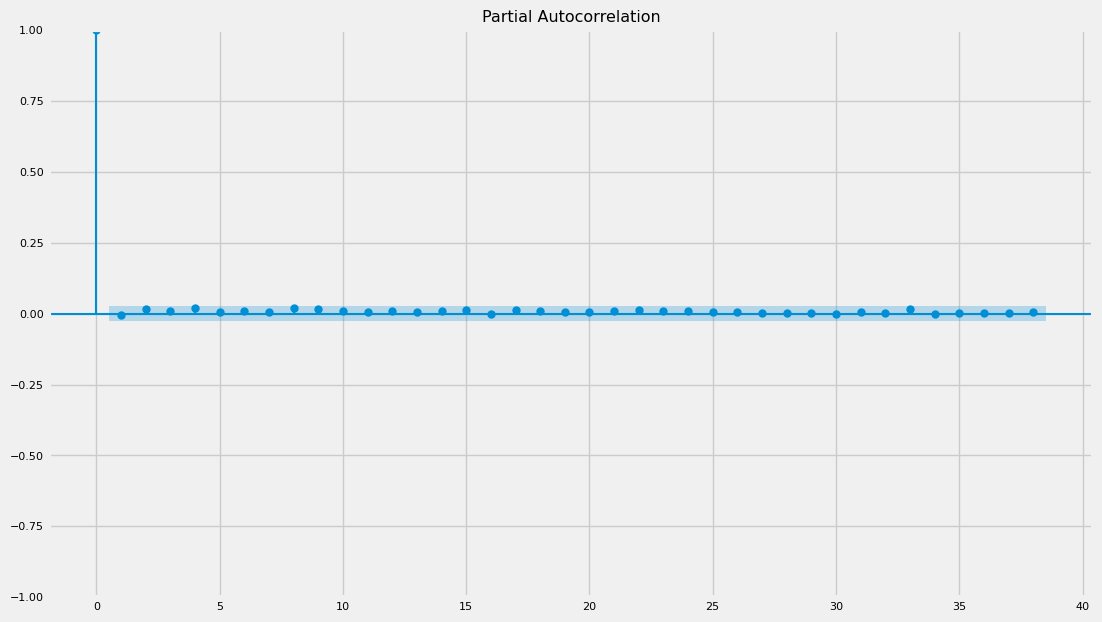

In [20]:
plot_pacf(st_residuals**2); print()

In [49]:
# Ljung Box test for autocorrelation in residuals
lb_test = acorr_ljungbox(df1**2, lags=max_lags)
lb_test
#for lag in range(max_lags):
#    print('lag: ' + str(lag) + 'p-val: ' + str(np.round(lb_test[lag], 4)))

,lb_stat,lb_pvalue
1,19.964970,7.887399e-06
2,38.996594,3.404060e-09
3,49.365869,1.090274e-10
4,59.783425,3.221337e-12
5,63.367823,2.442687e-12


In [50]:
lb_test = acorr_ljungbox(st_residuals**2, lags=max_lags)
lb_test

,lb_stat,lb_pvalue
1,0.077508,0.780703
2,1.679658,0.431784
3,2.051796,0.561726
4,4.044199,0.400057
5,4.262313,0.512300


In [58]:
# Engle ARCG test
etest = het_arch(df1, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1], 4)))
print('pval F-test: ' + str(np.round(etest[1], 4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [59]:
# Engle ARCG test for resids
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1], 4)))
print('pval F-test: ' + str(np.round(etest[1], 4)))

pval Lagrange: 0.5195
pval F-test: 0.5195
